# Feed-forward Neural Network for Multi-class Image Classificication

Adapted from https://ryanwingate.com/intro-to-machine-learning/deep-learning-with-pytorch/classifying-fashion-mnist/

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [3]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchmetrics import Accuracy, Precision, Recall
import matplotlib.pyplot as plt
import timeit

### Load Data Set

We consider the Fashion-MNIST dataset from Zalando. This dataset consists of 60,000 training examples and 10,000 test examples. Each example is a 28x28 grayscale image and a corresponding label (target) from one of 10 classes. Thankfully, the dataset is included in PyTorch.

More info hee: https://github.com/zalandoresearch/fashion-mnist

In [4]:
train_data = datasets.FashionMNIST(root = "sample_data",
                                            train = True,
                                            download= True,  # download data from internet if not available at `root`
                                            transform = transforms.ToTensor()
                                  )


test_data = datasets.FashionMNIST(root = "sample_data",
                                            train = False,
                                            download= True,
                                            transform = transforms.ToTensor()
                                  )

100%|██████████| 26421880/26421880 [00:01<00:00, 19555559.88it/s]


Extracting sample_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to sample_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 300525.53it/s]


Extracting sample_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to sample_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5535427.55it/s]


Extracting sample_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17042049.72it/s]

Extracting sample_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/FashionMNIST/raw



### Visualizing the data

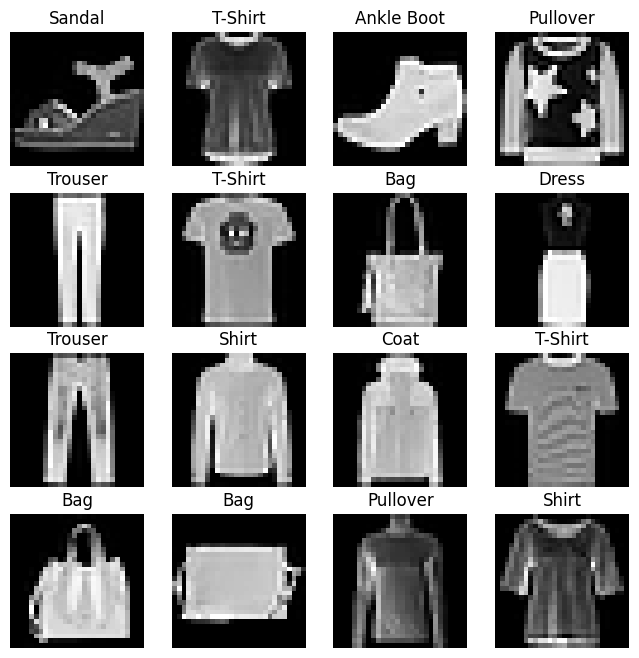

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Prepare data for training with DataLoaders

In [8]:
train_loader = DataLoader(train_data, batch_size=64, shuffle= True)
test_loader = DataLoader(test_data, batch_size=64, shuffle= True)

### Iterate through the DataLoader

Shape of feature batch: torch.Size([64, 1, 28, 28])
Shape of label batch: torch.Size([64])


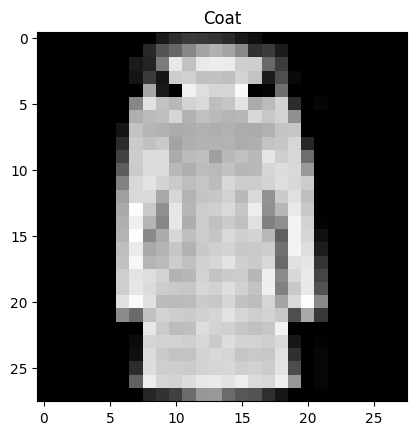

Label: 4


In [9]:
train_features, train_labels = next(iter(train_loader))
print(f'Shape of feature batch: {train_features.size()}')
print(f'Shape of label batch: {train_labels.size()}')

# Let's take the last sample in the training set (for example)
img = train_features[-1].squeeze()
label = train_labels[-1]
plt.imshow(img, cmap = "gray")
plt.title(labels_map[label.item()])
plt.show()
print(f'Label: {label}')

### Model Architecture

Recall that each image is of dimension 28 x 28 which leads to a total of 784 pixels per image. Also remember that we have 10 classes (labels)- multi-class classification problem.

In [10]:
image_size = train_data[0][0].shape[1]
n_pixels = image_size*image_size
n_classes = 10

In [12]:
image_size

28

In [11]:
model = nn.Sequential(nn.Linear(n_pixels, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, n_classes),
                      nn.LogSoftmax(dim = 1))

### Loss Function

In [ ]:
criterion = nn.NLLLoss() # negative log likelihood loss

### Optimizer

In [ ]:
lr = 1e-2 #3e-2
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

### Training

In [ ]:
num_epochs = 100
losses = []

start = timeit.default_timer()

for epoch in range(num_epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Flatten Fashion MNIST images to 784 long vector
        images = images.view(images.shape[0], -1)

        # set gradients to zero
        optimizer.zero_grad()

        # forward pass
        output = model(images)
        loss = criterion(output, labels)

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

        # sum losses in epoch
        running_loss += loss.item()

    # calculate mean of losses in epoch
    training_loss = running_loss/len(train_loader)

    # store losses
    losses.append(training_loss)

     # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss:.4f}')

# code to be timed
end = timeit.default_timer()
print(f"Elapsed time: {end - start} seconds")

Epoch [10/100], Loss: 0.4341
Epoch [20/100], Loss: 0.3707
Epoch [30/100], Loss: 0.3331
Epoch [40/100], Loss: 0.3017
Epoch [50/100], Loss: 0.2756
Epoch [60/100], Loss: 0.2551
Epoch [70/100], Loss: 0.2369
Epoch [80/100], Loss: 0.2207
Epoch [90/100], Loss: 0.2046
Epoch [100/100], Loss: 0.1919
Elapsed time: 787.3911052459998 seconds


### Inference on Test Data

In [ ]:
# helper function to print

def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

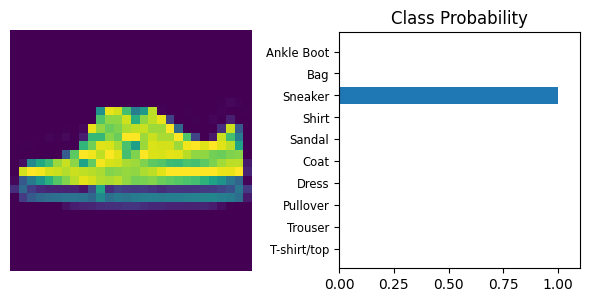

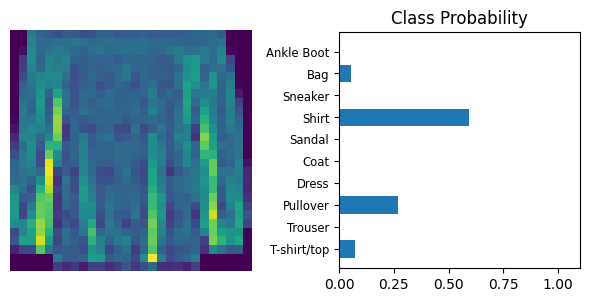

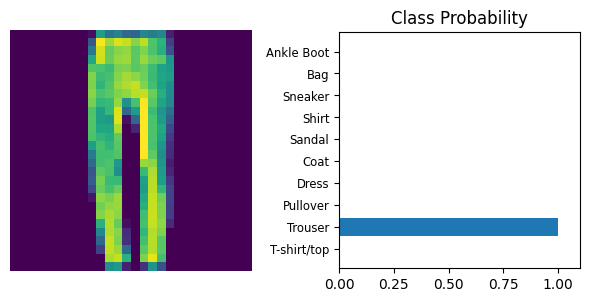

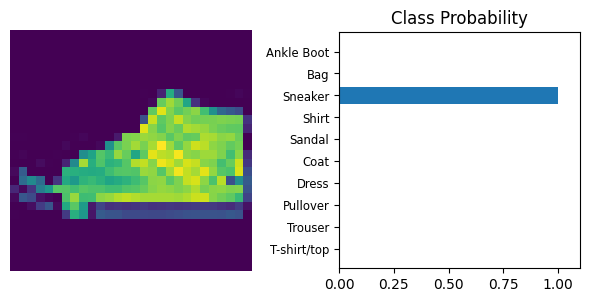

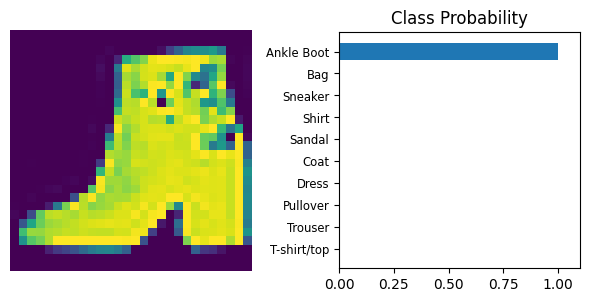

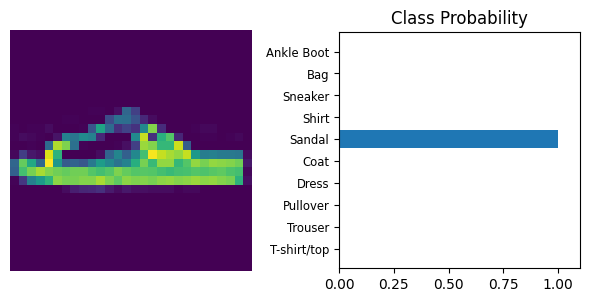

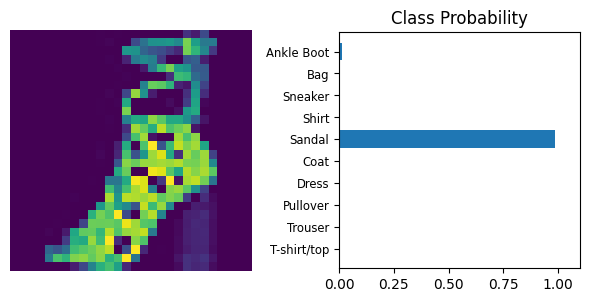

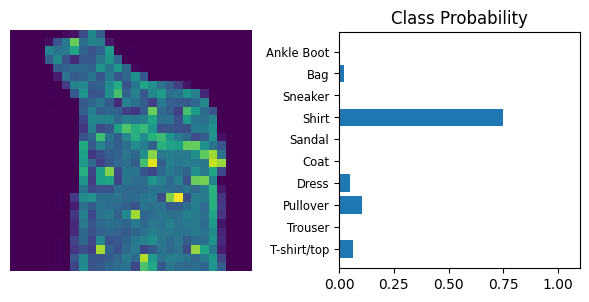

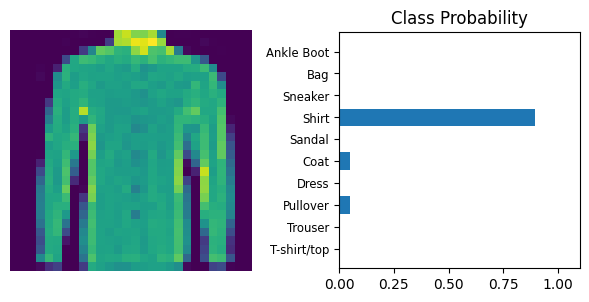

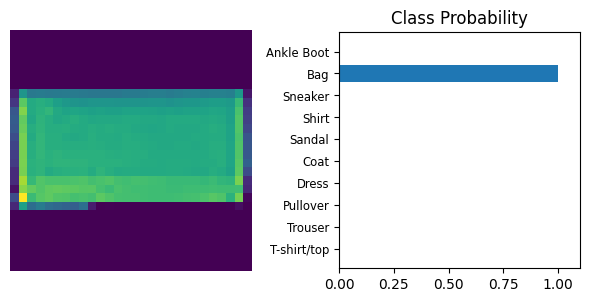

In [ ]:
dataiter = iter(test_loader)

for _ in range(10):
    try:
        images, labels = next(dataiter)
    except StopIteration:
        # Reinitialize the data loader iterator
        dataiter = iter(test_loader)
        images, labels = next(dataiter)

    img = images[0]

    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logps = model(img)
    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)

    # Plot the image and probabilities
    view_classify(img.resize_(1, 28, 28), ps)

### Model Performance/Metrics

In [ ]:
# Define the metrics
accuracy_metric = Accuracy(task='multiclass', num_classes=n_classes)
precision_metric = Precision(task='multiclass', num_classes=n_classes, average=None)
recall_metric = Recall(task='multiclass', num_classes=n_classes, average=None)

# Run model on test set
model.eval()
predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        outputs = model(images)
        _ , preds = torch.max(outputs, 1)
        accuracy_metric(preds, labels)
        precision_metric(preds, labels)
        recall_metric(preds, labels)

# Compute the metrics
accuracy = accuracy_metric.compute().item()
precision = precision_metric.compute().tolist()
recall = recall_metric.compute().tolist()
print(f'Accuracy: {accuracy:.2f}')
print('Precision (per class): ', precision)
print('Recall (per class):', recall)

Accuracy: 0.89
Precision (per class):  [0.8492723703384399, 0.9857288599014282, 0.8070707321166992, 0.8523676991462708, 0.8128128051757812, 0.9734423160552979, 0.7292929291725159, 0.9370764493942261, 0.9627391695976257, 0.9598393440246582]
Recall (per class): [0.8169999718666077, 0.9670000076293945, 0.7990000247955322, 0.9179999828338623, 0.8119999766349792, 0.953000009059906, 0.722000002861023, 0.9679999947547913, 0.9559999704360962, 0.9559999704360962]


# Homework

- Try different learning rates (typical values for lr between 1e-2 to 1e-4)
- Add the momentum parameter to the Stochastic Gradient Descent (SGD) optimizer. Typical values for momentum are within 0.85 - 0.99.
- Try the Adam optimizer instead of SGD
- Consider initializing the weights with the He/Kaiming Initialization
- Consider increasing the number of epochs
- Try another image dataset